In [1]:
import numpy as np
import pandas as pd
import cv2 as cv
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as f
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import MinMaxScaler

In [2]:
import os

# Get the directory path
directory_path = "/kaggle/input/covidqu/Infection Segmentation Data/Infection Segmentation Data/Train/Normal/images"

# Count the number of files in the directory
num_files = len(os.listdir(directory_path))

# Print the number of files
print(f"Number of files in the directory: {num_files}")

Number of files in the directory: 932


In [3]:
def get_data(path):
    categories = ['COVID-19', 'Non-COVID', 'Normal']
    data = []
    for category in categories:
        path_curr = path + f'{category}/images/'
        data_list = os.listdir(path_curr)
        for filename in data_list:
            data_curr = {}
            filepath_image = os.path.join(path_curr, filename)
            filepath_infection_mask = path + f'{category}/infection masks/{filename}'
            filepath_lung_mask = path + f'{category}/lung masks/{filename}'
            data_curr['image'] = filepath_image
            data_curr['infection_mask'] = filepath_infection_mask
            data_curr['lung_mask'] = filepath_lung_mask
            data_curr['category'] = category
            data.append(data_curr)
    return data

In [4]:
train_set = get_data('/kaggle/input/covidqu/Infection Segmentation Data/Infection Segmentation Data/Train/')
print(f'Train set length: {len(train_set)}')
valid_set = get_data('/kaggle/input/covidqu/Infection Segmentation Data/Infection Segmentation Data/Val/')
print(f'Valid set length: {len(valid_set)}')
test_set = get_data('/kaggle/input/covidqu/Infection Segmentation Data/Infection Segmentation Data/Test/')
print(f'Test set length: {len(test_set)}')

Train set length: 3728
Valid set length: 932
Test set length: 1166


255


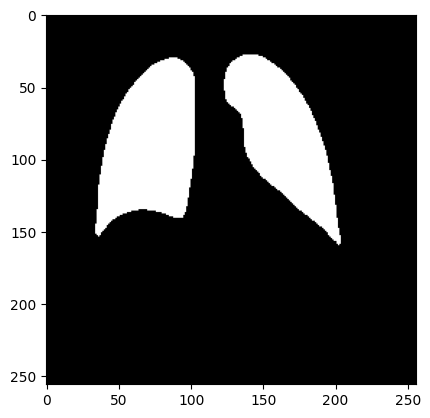

In [5]:
test = cv.imread('/kaggle/input/covidqu/Infection Segmentation Data/Infection Segmentation Data/Train/COVID-19/lung masks/covid_100.png')
plt.imshow(test)
print(np.max(test))

In [6]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])


In [7]:
mms = MinMaxScaler()

In [27]:
class CustomDataset(Dataset):
    def __init__(self, data, transform, scaler):
        self.data = data
        self.transform = transform
        self.scaler = scaler
    def __getitem__(self, index):
        lung_mask_path = self.data[index]['lung_mask']
        image_path = self.data[index]['image']
        image = np.array(cv.imread(image_path))[:,:,0]
        lung_mask = np.array(cv.imread(lung_mask_path))[:,:,0]
        X = self.transform(image)
        print(X.shape)
        X = self.scaler.fit_transform(X[0])
        X = np.expand_dims(X, 0)
        
        infection_mask_path = self.data[index]['infection_mask']
        infection_mask = np.array(cv.imread(infection_mask_path))[:,:,0]
        all_mask = np.zeros_like(infection_mask)
        all_mask[np.where(lung_mask == 255)] = 125
        all_mask[np.where(infection_mask == 255)] = 255
        y = self.transform(all_mask)
        return X, y
    def __len__(self):
        return len(self.data)

In [28]:
train_cd = CustomDataset(train_set, transform, mms)
train_loader = DataLoader(train_cd, batch_size = 16, shuffle = True)
valid_cd = CustomDataset(valid_set, transform, mms)
valid_loader = DataLoader(valid_cd, batch_size = 8, shuffle = False)
test_cd = CustomDataset(test_set, transform, mms)
test_loader = DataLoader(test_cd, batch_size = 1, shuffle = False)

torch.Size([1, 128, 128])


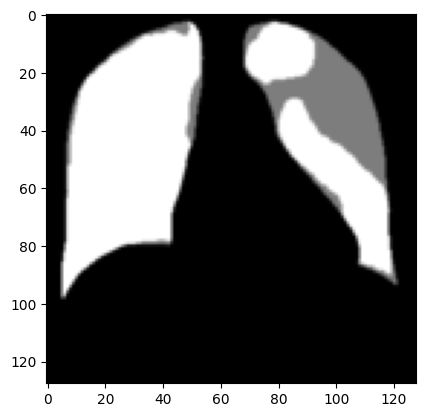

In [31]:
plt.imshow(train_cd[100][1].squeeze(0), cmap = 'gray')

In [15]:
class Model(nn.Module):
    def __init__(self):
        super(Model,self).__init__()
        self.conv3x3_1 = nn.Sequential(
            nn.Conv2d(in_channels = 1, out_channels = 64, kernel_size = 3, padding = 'same'),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace = True),
            nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, padding = 'same'),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace = True)
        )
        self.conv3x3_2 = nn.Sequential(
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size = 3, padding = 'same'),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace = True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size = 3, padding = 'same'),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace = True)
        )
        self.conv3x3_3 = nn.Sequential(
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding = 'same'),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace = True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding = 'same'),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace = True)
        )
        self.conv3x3_4 = nn.Sequential(
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding = 'same'),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace = True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding = 'same'),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace = True)
        )
        self.conv3x3_5 = nn.Sequential(
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, padding = 'same'),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace = True),
            nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, padding = 'same'),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace = True)
        )
        self.upconv2x2_1 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=2,stride=2)
        self.conv3x3_6 = nn.Sequential(
            nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=3, padding = 'same'),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace = True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding = 'same'),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace = True)
        )
        self.upconv2x2_2 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=2,stride=2)
        self.conv3x3_7 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding = 'same'),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace = True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding = 'same'),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace = True)
        )
        self.upconv2x2_3 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=2,stride=2)
        self.conv3x3_8 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding = 'same'),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace = True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding = 'same'),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace = True)
        )
        self.upconv2x2_4 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=2,stride=2)
        self.conv3x3_9 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding = 'same'),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace = True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding = 'same'),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace = True)
        )
        self.output = nn.Sequential(
            nn.Conv2d(in_channels=64,out_channels=1,kernel_size=1),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

#     def crop(self, x, out_shape):
#         in_shape = x.shape[-1]
#         out = x[:,:,(in_shape-out_shape)//2:(in_shape-out_shape)//2+out_shape,(in_shape-out_shape)//2:(in_shape-out_shape)//2+out_shape]
#         return(out)
    def forward(self, x):
        cv1 = self.conv3x3_1(x)
#         print(f"Cv1: {cv1.size()}")
#         crop_cv1 = self.crop(cv1, 392)

        cv2 = self.conv3x3_2(cv1)
#         print(f"Cv2: {cv2.size()}")
#         crop_cv2 = self.crop(cv2, 200)

        cv3 = self.conv3x3_3(cv2)
#         print(f"Cv3: {cv3.size()}")
#         crop_cv3 = self.crop(cv3, 104)

        cv4 = self.conv3x3_4(cv3)
#         print(f"Cv4: {cv4.size()}")
#         crop_cv4 = self.crop(cv4, 56)

        cv5 = self.conv3x3_5(cv4)
#         print(f"Cv5: {cv5.size()}")

        upcv1 = self.upconv2x2_1(cv5)
#         print(f"UpCv1: {upcv1.size()}         CropCv4: {cv4.size()}")
        
        cv6 = self.conv3x3_6(torch.cat([cv4, upcv1], dim = 1))
#         print(f"Cv6: {cv6.size()}")

        upcv2 = self.upconv2x2_2(cv6)
#         print(f"UpCv2: {upcv2.size()}         CropCv3: {cv3.size()}")
        cv7 = self.conv3x3_7(torch.cat([cv3, upcv2], dim = 1))

        upcv3 = self.upconv2x2_3(cv7)
#         print(f"UpCv3: {upcv3.size()}         CropCv2: {cv2.size()}")
        cv8 = self.conv3x3_8(torch.cat([cv2, upcv3], dim = 1))

        upcv4 = self.upconv2x2_4(cv8)
#         print(f"UpCv4: {upcv4.size()}         CropCv1: {cv1.size()}")
        cv9 = self.conv3x3_9(torch.cat([cv1, upcv4], dim = 1))

        out = self.output(cv9)

        return out


In [16]:
def train(dataloader, model, loss_fn, optimizer):
    model.train()
    losses = np.array([])
    for X, y in tqdm(dataloader):
        # Compute prediction error
        pred = model(X.cuda())
        # class_pred = torch.argmax(pred, dim = -1)
        loss = loss_fn(pred, y.cuda())
#         print(loss)
        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        losses = np.append(losses, loss.item())

    loss_mean = losses.mean()
    print(f"loss mean per batch: {loss_mean:.20f}")
    return loss_mean

In [17]:
def validating(dataloader, model, loss_fn):

    num_batches = len(dataloader)
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.cuda(), y.cuda()
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            # correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    print(f"Test Error: \n Avg loss per batch: {test_loss:.20f} \n")
    return test_loss

In [18]:
model = Model().cuda()
criterion = nn.BCELoss()
optimizer =  torch.optim.Adam(model.parameters(),
                          lr=0.001, weight_decay = 0.00000001, foreach=True)

In [ ]:
train_losses = []
val_losses = []

In [10]:
epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_losses.append(train(train_loader, model, criterion, optimizer))
    val_losses.append(validating(valid_loader, model, criterion))
print("Done!")

Epoch 1
-------------------------------


100%|██████████| 233/233 [01:58<00:00,  1.96it/s]


loss mean per batch: 0.03930056039163994791
Test Error: 
 Avg loss per batch: 0.07159954658908466996 

Epoch 2
-------------------------------


100%|██████████| 233/233 [01:57<00:00,  1.98it/s]


loss mean per batch: 0.03820335336605110849
Test Error: 
 Avg loss per batch: 0.08971350649212542216 

Epoch 3
-------------------------------


100%|██████████| 233/233 [01:57<00:00,  1.98it/s]


loss mean per batch: 0.03504165537383550910
Test Error: 
 Avg loss per batch: 0.12622344260239320990 

Epoch 4
-------------------------------


100%|██████████| 233/233 [01:57<00:00,  1.98it/s]


loss mean per batch: 0.03486811419221464564
Test Error: 
 Avg loss per batch: 0.13828874623371112396 

Epoch 5
-------------------------------


100%|██████████| 233/233 [01:58<00:00,  1.97it/s]


loss mean per batch: 0.03445856024954836033
Test Error: 
 Avg loss per batch: 0.09132056298832862129 

Epoch 6
-------------------------------


100%|██████████| 233/233 [01:59<00:00,  1.95it/s]


loss mean per batch: 0.03256066455685657779
Test Error: 
 Avg loss per batch: 0.06654824883255183732 

Epoch 7
-------------------------------


100%|██████████| 233/233 [01:58<00:00,  1.96it/s]


loss mean per batch: 0.03151787235101789070
Test Error: 
 Avg loss per batch: 0.07081604399519343673 

Epoch 8
-------------------------------


100%|██████████| 233/233 [01:57<00:00,  1.98it/s]


loss mean per batch: 0.02725185092554583549
Test Error: 
 Avg loss per batch: 0.06724986373486681324 

Epoch 9
-------------------------------


100%|██████████| 233/233 [01:57<00:00,  1.98it/s]


loss mean per batch: 0.02551958003269244601
Test Error: 
 Avg loss per batch: 0.06506486185706961134 

Epoch 10
-------------------------------


100%|██████████| 233/233 [01:57<00:00,  1.98it/s]


loss mean per batch: 0.03240001379500258988
Test Error: 
 Avg loss per batch: 0.06725237427207712837 

Done!


In [8]:
print(train_losses)

[0.4317645041727713, 0.37388715813088313, 0.32176222847255004, 0.2832783724744944, 0.24926974947360453, 0.22565406439386212, 0.19996343994345275, 0.1815323096104446, 0.1705322770217969, 0.1548332539367062, 0.1440317482075978, 0.13461184543217714, 0.12632989528481028, 0.12232778886484998, 0.11285104599377628, 0.1055026961882227, 0.09945283053131063, 0.09512461037594873, 0.09169439584528427, 0.08751321764654868, 0.08335807224008147, 0.0814460279667838, 0.08081417011153033, 0.07549431131824914, 0.07143912557112812, 0.06944856557659325, 0.06874773660954488, 0.06382447253321118, 0.06302590658608424, 0.061741051372028725, 0.06086345613322545, 0.05809041327704943, 0.05626454317838337, 0.054528724953788035, 0.05492429185834565, 0.05283060003983361, 0.049343532127180324, 0.046538940842699085, 0.04412240953916132, 0.042186577968267414]


In [9]:
print(val_losses)

[0.3716157218839368, 0.5705446440439957, 0.3105859737365674, 0.28266102177465063, 0.22881072186506712, 0.34041153811491454, 0.19533563564475784, 0.15980231214282858, 0.15423820422500625, 0.14587964735224715, 0.21917277103305882, 0.13410127232981545, 0.12348703622945353, 0.11194767268040241, 0.10350157530644001, 0.09868733807761446, 0.09021477283448236, 0.11522247871527305, 0.11623410374308243, 0.0784443204697126, 0.07725750350862996, 0.07917620953267966, 0.07811960601844849, 0.06897548985723247, 0.1125476667100293, 0.21376910548593497, 0.0665323446926653, 0.07071684620096388, 0.0675190569132439, 0.07771754058666973, 0.190846525451057, 0.06789395947837168, 0.12191107160706297, 0.059215214485541366, 0.06972707181563999, 0.06480355376107061, 0.0625873589888215, 0.15337678071302482, 0.08844820687021965, 0.0878378229542102]


In [1]:
torch.save(model.state_dict(), "/kaggle/working/model.pt")

In [ ]:
from pathlib import Path
model = Model()
checkpoint = torch.load(Path('/kaggle/working/model.pt'))
model.load_state_dict(checkpoint)
model.eval()
model = model.cuda()

torch.Size([256, 256])


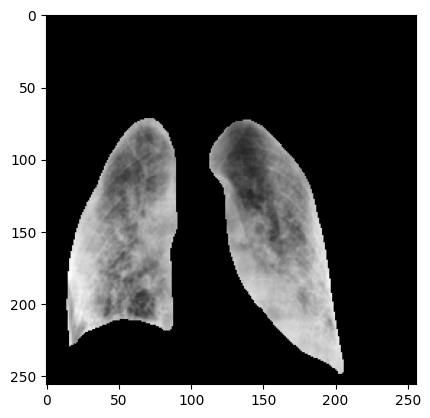

In [5]:
test_1 = test_cd[100][0].squeeze(0)
print(test_1.shape)
plt.imshow(test_1, cmap = 'gray')

In [6]:
print(test_1.unsqueeze(0).shape)

torch.Size([1, 256, 256])


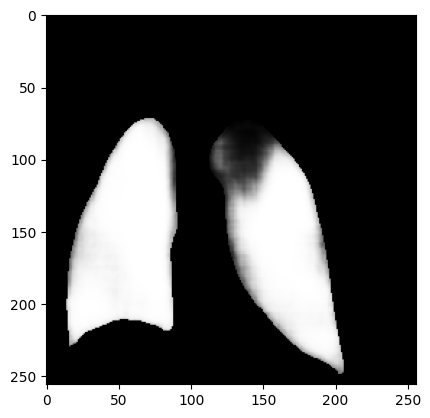

In [7]:
pred_1 = model(test_1.unsqueeze(0).unsqueeze(0).cuda())
plt.imshow(pred_1.detach().cpu().squeeze(), cmap= "gray")

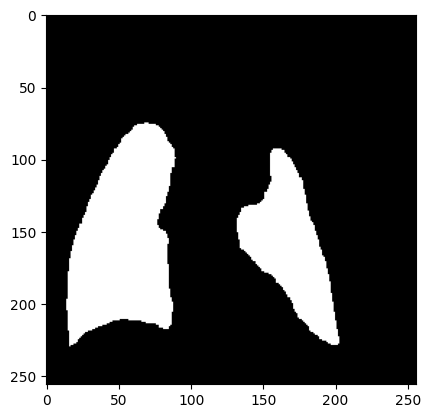

In [9]:
plt.imshow(test_cd[100][1].squeeze(0), cmap = 'gray')